In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm
import io
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [2]:
# Confirmer les chemins des fichiers
for dirname, _, filenames in os.walk(r"C:\Users\Siyam\Desktop\Ingé 2\Brain Detection\Brain-Tumor-Classification"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\Users\Siyam\Desktop\Ingé 2\Brain Detection\Brain-Tumor-Classification\desktop.ini
C:\Users\Siyam\Desktop\Ingé 2\Brain Detection\Brain-Tumor-Classification\Testing\glioma_tumor\image(1).jpg
C:\Users\Siyam\Desktop\Ingé 2\Brain Detection\Brain-Tumor-Classification\Testing\glioma_tumor\image(10).jpg
C:\Users\Siyam\Desktop\Ingé 2\Brain Detection\Brain-Tumor-Classification\Testing\glioma_tumor\image(100).jpg
C:\Users\Siyam\Desktop\Ingé 2\Brain Detection\Brain-Tumor-Classification\Testing\glioma_tumor\image(11).jpg
C:\Users\Siyam\Desktop\Ingé 2\Brain Detection\Brain-Tumor-Classification\Testing\glioma_tumor\image(12).jpg
C:\Users\Siyam\Desktop\Ingé 2\Brain Detection\Brain-Tumor-Classification\Testing\glioma_tumor\image(13).jpg
C:\Users\Siyam\Desktop\Ingé 2\Brain Detection\Brain-Tumor-Classification\Testing\glioma_tumor\image(14).jpg
C:\Users\Siyam\Desktop\Ingé 2\Brain Detection\Brain-Tumor-Classification\Testing\glioma_tumor\image(15).jpg
C:\Users\Siyam\Desktop\Ingé 2\Brain Detection\Brain

In [3]:
# Récupérer les classes
classes = os.listdir(r"C:\Users\Siyam\Desktop\Ingé 2\Brain Detection\Brain-Tumor-Classification\Training")
print(classes)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [4]:
X = [] # images 
y = [] # classes
image_size = 150 # taille des images

In [5]:
from PIL import Image

# Boucle sur les dossiers Training et Testing
for dataset_type in ["Training", "Testing"]:
    for class_name in classes: # Boucle sur les classes
        folder_path = os.path.join(r"C:\Users\Siyam\Desktop\Ingé 2\Brain Detection\Brain-Tumor-Classification", dataset_type, class_name) # Chemin du dossier de la classe actuelle

        # Boucle sur les fichiers du dossier actuel
        for image_file in tqdm(os.listdir(folder_path)):
            img_path = os.path.join(folder_path, image_file) # Chemin de l'image actuelle
            try:
                img = Image.open(img_path) # Ouvrir l'image
                img = img.resize((image_size, image_size)) # Redimensionner l'image
                img_array = np.array(img) # Convertir l'image en tableau numpy
                if len(img_array.shape) != 3 or img_array.shape[2] != 3: # Vérifier que l'image est en couleur (3 canaux)
                    print(f"Image sans les 3 canaux pour {img_path}")
                    continue
                X.append(img_array) # Ajouter l'image au tableau X
                y.append(class_name) # Ajouter la classe au tableau y
            except Exception as e:
                print(f"Impossible d'ouvrir l'image {img_path}: {e}")

100%|██████████| 74/74 [00:00<00:00, 144.01it/s]


In [6]:
X = np.array(X) # convertir la liste des images en tableau
y = np.array(y) # convertir la liste des classes en tableau

In [7]:
print(f"Nombre d'images chargées: {len(X)}") 
print(f"Nombre de label chargées: {len(y)}")
print(X.shape, y.shape) # Afficher la taille d'échantillon de X et y, ainsi que la taille d'une image et ses canaux

Nombre d'images chargées: 3264
Nombre de label chargées: 3264
(3264, 150, 150, 3) (3264,)


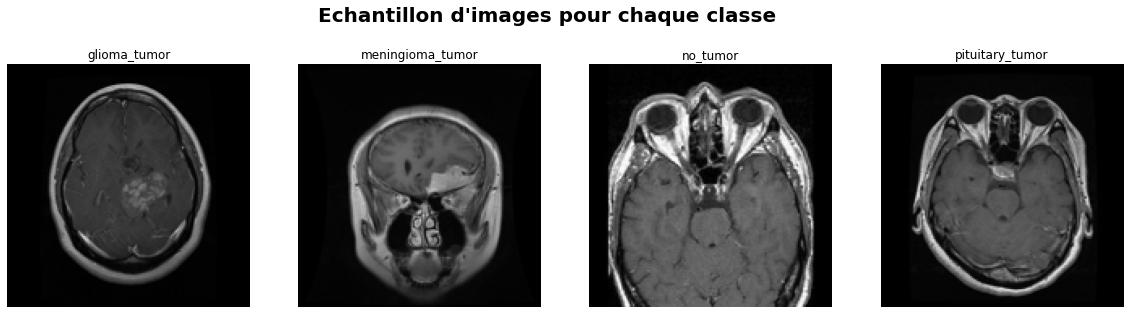

In [8]:
k = 0 # index pour les images
figure, ax = plt.subplots(1,4,figsize=(20,20)) # 1 ligne, 4 colonnes
figure.text(s="Echantillon d'images pour chaque classe", size=20,fontweight='bold',y=0.62,x=0.5,ha='center',va='center')
for i in classes:
    j=0 # index pour les classes
    while True :
        if y[j]==i: # si la classe y[j] est égale à i
            ax[k].imshow(X[j]) # afficher l'image correspondante à la X[j]
            ax[k].set_title(y[j]) # afficher la classe de l'image en titre
            ax[k].axis('off') # ne pas afficher les axes
            k+=1
            break
        j+=1

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42) # 80% pour le training et 20% pour le test

In [10]:
y_train_new = [] # liste pour les classes du training
for i in y_train: 
    y_train_new.append(classes.index(i)) # remplacer les noms des classes par leurs indices
y_train = y_train_new # mettre à jour les classes du training
y_train = tf.keras.utils.to_categorical(y_train) # convertir les classes en one-hot encoding

y_test_new = [] # liste pour les classes du test
for i in y_test: 
    y_test_new.append(classes.index(i)) # remplacer les noms des classes par leurs indices
y_test = y_test_new # mettre à jour les classes du test
y_test = tf.keras.utils.to_categorical(y_test) # convertir les classes en one-hot encoding

In [11]:
img_datagen = ImageDataGenerator( # faire de la data augmentation
    rotation_range=30, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    zoom_range=0.2, 
    horizontal_flip=True) 

img_datagen.fit(X_train) # Fit la data augmentation
img_datagen.fit(X_test) # fit la data augmentation

In [12]:
# Récupérer le modèle VGG19
base_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3), pooling=None)

In [13]:
# Ne pas entraîner les couches du modèle VGG19
for layer in base_model.layers:
    layer.trainable = False

# Ajouter les couches personnalisées
model = Sequential()
model.add(base_model)
model.add(GlobalMaxPooling2D())  # Utiliser GlobalMaxPooling2D() pour VGG19
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax'))  # 4 classes

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 20,289,092
Trainable params: 264,708
Non-trainable params: 20,024,384
_________________________________________________________________


In [14]:
# Compiler le modèle
model.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [16]:
# Entraîner le modèle
history = model.fit(X_train,y_train,validation_split=0.1, epochs=10, verbose=1, batch_size=32)

Epoch 1/10
74/74 [==============================] - 170s 2s/step - loss: 4.7423 - accuracy: 0.6522 - val_loss: 3.8891 - val_accuracy: 0.6756
Epoch 2/10
74/74 [==============================] - 177s 2s/step - loss: 1.2072 - accuracy: 0.8212 - val_loss: 2.0952 - val_accuracy: 0.7176
Epoch 3/10
74/74 [==============================] - 166s 2s/step - loss: 0.6944 - accuracy: 0.8753 - val_loss: 1.4984 - val_accuracy: 0.7710
Epoch 4/10
74/74 [==============================] - 170s 2s/step - loss: 0.4218 - accuracy: 0.9029 - val_loss: 1.1716 - val_accuracy: 0.8282
Epoch 5/10
74/74 [==============================] - 162s 2s/step - loss: 0.1978 - accuracy: 0.9472 - val_loss: 1.3555 - val_accuracy: 0.7863
Epoch 6/10
74/74 [==============================] - 161s 2s/step - loss: 0.1997 - accuracy: 0.9476 - val_loss: 1.2618 - val_accuracy: 0.8206
Epoch 7/10
74/74 [==============================] - 161s 2s/step - loss: 0.1136 - accuracy: 0.9689 - val_loss: 1.2799 - val_accuracy: 0.8282
Epoch 8/10
74

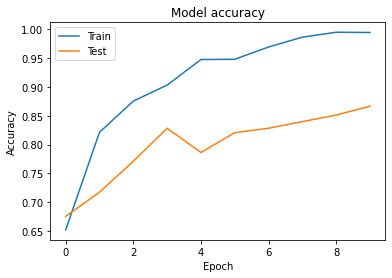

In [17]:
# Evaluer le modèle
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

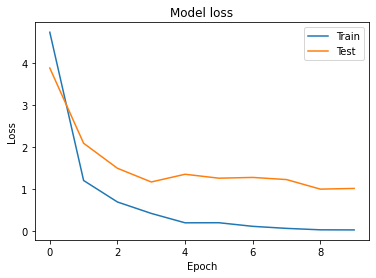

In [18]:
# Evaluer le modèle
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

82/82 [==============================] - 175s 2s/step
Training accuracy = 0.9862
Training F1 score = 0.9862


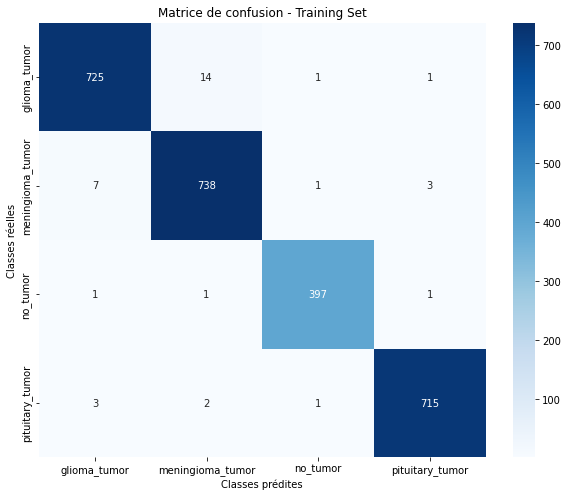

21/21 [==============================] - 44s 2s/step
Testing Accuracy = 0.8683
Testing F1 score = 0.8687


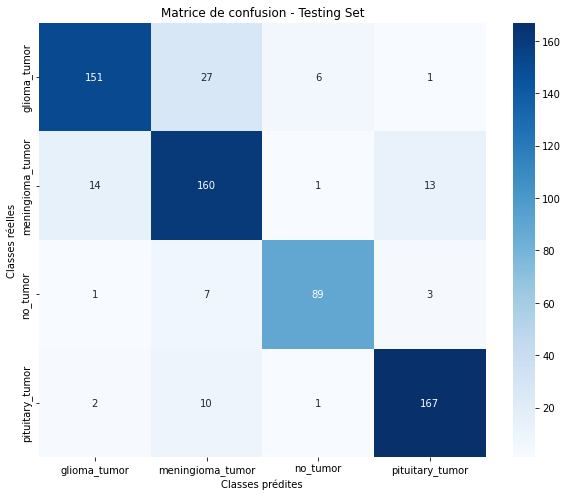

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Tester le modèle sur le training set
predictions_tr = model.predict(X_train)
predictions_tr = [np.argmax(x) for x in predictions_tr]

accuracy_tr = accuracy_score(np.argmax(y_train, axis=1), predictions_tr)
print('Training accuracy = %.4f' % accuracy_tr)

f1_tr = f1_score(np.argmax(y_train, axis=1), predictions_tr, average='weighted')
print('Training F1 score = %.4f' % f1_tr)

confusion_mtx_tr = confusion_matrix(np.argmax(y_train, axis=1), predictions_tr)

# Plot la matrice de confusion pour le training set
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx_tr, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Classes prédites')
plt.ylabel('Classes réelles')
plt.title('Matrice de confusion - Training Set')
plt.show()

# Tester le modèle sur le testing set
predictions_test = model.predict(X_test)
predictions_test = [np.argmax(x) for x in predictions_test]

accuracy_test = accuracy_score(np.argmax(y_test, axis=1), predictions_test)
print('Testing Accuracy = %.4f' % accuracy_test)

f1_test = f1_score(np.argmax(y_test, axis=1), predictions_test, average='weighted')
print('Testing F1 score = %.4f' % f1_test)

confusion_mtx_test = confusion_matrix(np.argmax(y_test, axis=1), predictions_test)

# Plot la matrice de confusion pour le testing set
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx_test, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Classes prédites')
plt.ylabel('Classes réelles')
plt.title('Matrice de confusion - Testing Set')
plt.show()

In [20]:
# Classification Report
y_test_labels = [np.argmax(label) for label in y_test] # Récupérer les labels du testing set
# Afficher le classification report
print("Classification Report:\n", classification_report(y_test_labels, predictions_test, target_names=classes))

Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.90      0.82      0.86       185
meningioma_tumor       0.78      0.85      0.82       188
        no_tumor       0.92      0.89      0.90       100
 pituitary_tumor       0.91      0.93      0.92       180

        accuracy                           0.87       653
       macro avg       0.88      0.87      0.87       653
    weighted avg       0.87      0.87      0.87       653

